In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [9]:
co2_df = pd.read_csv("../ts-course-data/co2.csv", index_col = "Date", parse_dates=True)
co2_df.index.freq = "MS"

In [11]:
co2_df.head(5)

,CO2
Date,
1959-01-01,315.42
1959-02-01,316.31
1959-03-01,316.50
1959-04-01,317.56
1959-05-01,318.13


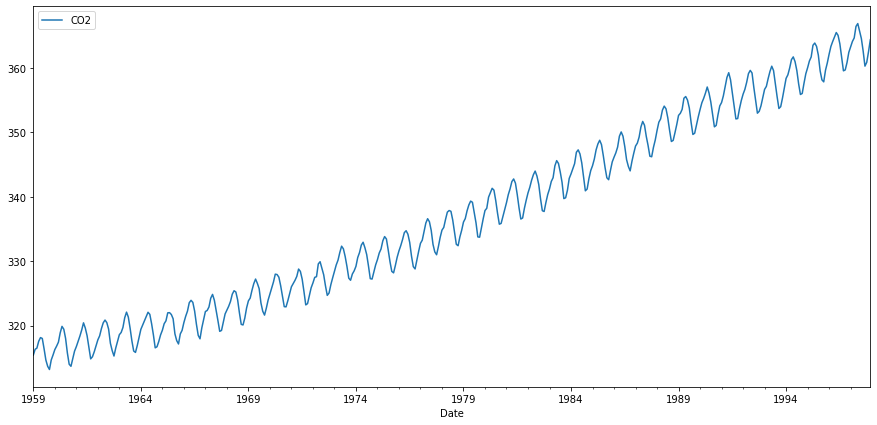

In [14]:
co2_df.plot(figsize = (15, 7))
plt.show()